# Bullying recognition from Tweeter Corpus, build on recent events

# 1. Program Execution

# 2. Service Functions

## 2.1. Imports 

In [19]:
# Load libraries
import pandas as pd 
from pandas import DataFrame
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt
import sklearn
from sklearn import tree 
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import requests
from geopy.geocoders import Nominatim
from geopy.distance import vincenty
import json
import difflib
import copy
from pprint import pprint
import csv
import numpy as np
import re
import csv
import json
import xlwt
import re

### The snippet of code below reads the file, which containes the tweets in json fromat, gatherered by streiming the tweeter


In [20]:
#Reading the file
def ParseFileIntoJson(file):
    TweetsJsonArray = []
    TweetsJsonArray2 = []
    myArray = []
    i=0
    with open(file) as f:
        for line in f:
            i=i+1
            line2=line.lstrip()        
            if line2!='':                
                TweetsJsonArray.append(json.loads(line2))            
    return TweetsJsonArray
    #with open(file,encoding='utf-8') as f:
        #content = f.readlines()
    #Getting rid of empty strings
    #content =  [x.strip() for x in content]
    #content = list(filter(None, content)) 
    
    #To JSON TYPE
    #for tweet in content:
        #TweetsJsonArray.append(json.loads(tweet))  

In [21]:
# 1 Parse File with tweets json
TweetsJsonArray=ParseFileIntoJson('pythonRefugees.json')
# Pocess Json, Write in Exel

#Sort Tweet for repitions retrieval and retweeters gathering

## 2.2 Loading Dictionaries

In [22]:
collectivenouns=[]
pronouns=[]
offensiveWords = dict() 
xl = pd.ExcelFile("Dictionary.xlsx")

df = xl.parse("OffensiveWords")
l = len(df)
for i in range(l)[1:]:
    offensiveWords[(df['Word'][i]).lower()]=df['Weight'][i]
    
df = xl.parse("Nouns")
l = len(df)
for i in range(l)[1:]:
    collectivenouns.append((df['Collective Nouns'][i]).lower()) 
    
df = xl.parse("Pronouns")
l = len(df)
for i in range(l)[1:]:
    pronouns.append(df['Personal Pronouns'][i])

## 2.3. Functions

### 2. The code snippet below contains the functions, used accross the project, such as the Offensiveness level calculation, two tweets similarity calculation 

In [23]:
#Preprocessing - deleting the similar tweets- deciede that it is not needed
import difflib
def similar(a, b):
    return difflib.SequenceMatcher(None, a, b).ratio()
#Calculating the offinsiveness level

def offensiveness_weight(TweetText):        
        templist = TweetText.split()
        offensiveWordsList=list(offensiveWords.keys())
        temp = set(offensiveWordsList).intersection(templist)
        my_list = list(temp)        
        final = 0
        result=0
        
        if len(my_list)!=0:
            for word in my_list:                
                final = float(final) + float(offensiveWords[word])        
            result = final / len(my_list)
        return result
    
#Identifying the existance of the words

def wordpresence(TweetText,wordlist):
    templist1= TweetText.split()    
    temp1 = set(wordlist).intersection(templist1) 
    my_list1 = list(temp1)    
    if len(my_list1)!=0:
        return 1
    else:
        return 0
# If 
def offensive_level(TweetText):
    
    nounsExistance = wordpresence(TweetText,collectivenouns)    
    pronounsExistance = wordpresence(TweetText,pronouns)
    
    if offensiveness_weight(TweetText) > 0 and (wordpresence or pronounsExistance) :    
        return (offensiveness_weight(TweetText) + 1)/6 * 100
    else:
        return (offensiveness_weight(TweetText))/6 * 100
#Count how many words from the wordlist parameter are in tweet
def WordCount(TweetText,wordlist):
    templist1= TweetText.split()    
    temp1 = set(wordlist).intersection(templist1) 
    my_list1 = list(temp1)     
    return len(my_list1)
def GeoLocationByTweetLocation(location):    
    
    try:
        geolocator = Nominatim()    
        location = geolocator.geocode(location)
        return (str(location.latitude)+";" +str(location.longitude))
    except :
        return ""
       
def distance(u,v):
    return vincenty(u, v).miles

def getLocationByCoordinates(c):
    location = geolocator.reverse(c)
    return location


In [24]:
GeoLocationByTweetLocation('Canada')
        

'61.0666922;-107.9917071'

## 2.4 Third Party Libriries

In [25]:
import requests
def SentimentalAnalysis(tweet):
    r = requests.post("http://text-processing.com/api/sentiment/", data={'text': tweet})
    label= r.json()['label']
    if label =='neutral':
        return 0
    elif label=='positive':
        return 1
    else :        
        return 2          

# 3. Preprocessing

In [26]:
#Writing the content to the exel for Manual Analysis
def Processing(TweetsJsonArray):
    geolocator = Nominatim()
    num=1;
    book = xlwt.Workbook()
    sheet1 = book.add_sheet("Sheet1",cell_overwrite_ok=True)
    row = sheet1.row(0)
    row.write(0, 'Text')  
    row.write(1, 'Description')    
    row.write(2, 'Offensiveness Weight')
    row.write(3, 'Offensiveness Level')
    row.write(4, 'Offensive Words Amount')
    row.write(5,'Sentimental Analysis')
    row.write(6,'Class')
    row.write(7,'Geo_Location')
    row =1
    for tweet in TweetsJsonArray:      
        
        if tweet['lang']=="en":
            if num % 50==0:
                print (num)
            row = sheet1.row(num)             
            text=''
            if 'extended_tweet' in tweet:
                text=tweet['extended_tweet']['full_text']
            elif 'retweeted_status' in tweet:
                if 'extended_tweet' in tweet['retweeted_status']:
                    text=tweet['retweeted_status']['extended_tweet']['full_text']
                else:
                    text=tweet['retweeted_status']['text']
            else:
                text=tweet['text']
            text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',text)
            names = tweet['user']['name']
            description = tweet['user']['description']

            #text = re.sub(r'\W+', '', text)

            PERMITTED_CHARS = "0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ_- "
            text = "".join(c for c in text if c in PERMITTED_CHARS)
            text=text.lower()
            text=text.strip()
            names="".join(c for c in names if c in PERMITTED_CHARS)
            description="".join(c for c in description if c in PERMITTED_CHARS) if description!= None else ''
            description=description.lower()
            description=description.strip()     
            location=""
            if 'location' in tweet['user']:
                if tweet['user']['location']!='nan' and tweet['user']['location']!='':
                    location=GeoLocationByTweetLocation(tweet['user']['location'])              
            row.write(0, text)           
            row.write(1, description)               
            row.write(7, location)
            num=num+1

    book.save("TweetCorpusExel.xls")
    #csvFile.writerow([tweet["created_at"],tweet["text"],tweet["user"]["name"],tweet["user"]["description"],tweet["user"]["location"]])

In [27]:
def Processing2(TweetsJsonArray):
    geolocator = Nominatim()
    num=1;
    book = xlwt.Workbook()
    sheet1 = book.add_sheet("Sheet1",cell_overwrite_ok=True)
    row = sheet1.row(0)
    writer = pd.ExcelWriter('TweetCorpusExel.xlsx')
    df = DataFrame(columns=('Text', 'Description', 'Offensiveness Weight','Offensiveness Level','Offensive Words Amount',
                           'Sentimental Analysis','Class','Geo_Location'))
 
    
    row =1
    n=0
    for tweet in TweetsJsonArray:        
        if n % 50==0:
            print (n)
        if tweet['lang']=="en":            
            row.write(0, tweet['created_at'])  
            text=''
            if 'extended_tweet' in tweet:
                text=tweet['extended_tweet']['full_text']
            elif 'retweeted_status' in tweet:
                if 'extended_tweet' in tweet['retweeted_status']:
                    text=tweet['retweeted_status']['extended_tweet']['full_text']
                else:
                    text=tweet['retweeted_status']['text']
            else:
                text=tweet['text']
            text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',text)
            names = tweet['user']['name']
            description = tweet['user']['description']

            #text = re.sub(r'\W+', '', text)

            PERMITTED_CHARS = "0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ_- "
            text = "".join(c for c in text if c in PERMITTED_CHARS)
            text=text.lower()
            text=text.strip()
            names="".join(c for c in names if c in PERMITTED_CHARS)
            description="".join(c for c in description if c in PERMITTED_CHARS) if description!= None else ''
            description=description.lower()
            description=description.strip()     
            location=""
            if 'location' in tweet['user']:
                if tweet['user']['location']!='nan' and tweet['user']['location']!='':
                    location=GeoLocationByTweetLocation(tweet['user']['location']) 
            df.loc[n]=[text, description,'','','','','',location]            
            n=n+1           

    df.to_excel(writer,'Sheet1',index=False)
    writer.save()
    writer.close()

### 3.1 Sort the tweets in the file

In [28]:
def SortExel():
    xl = pd.ExcelFile("TweetCorpusExel1.xls")
    df = xl.parse("Sheet1")
    df = df.sort_values(by="Text")
    writer = pd.ExcelWriter('TweetCorpusExel2.xlsx')
    df.to_excel(writer,'Sheet1',index=False)
    writer.save()
    writer.close()

### 3.2 Delete repeating tweets

In [29]:
def DeleteRepititions():
    df = pd.read_excel('TweetCorpusExel2.xlsx', sheetname='Sheet1')
    writer = pd.ExcelWriter('TweetCorpusExel3.xlsx')
    currentrow=0
    if str(df['Description'][currentrow])!='nan':
        df['Text'][currentrow]=str(df['Text'][currentrow])+" \n <::> "+str(df['Description'][currentrow])
    tweet=str(df['Text'][currentrow])

    l = len(df)
    num=0
    for i in range(l)[1:]:  
        if num % 100==0:
                print (num)
        num=num+1
        if df['Text'][i]==tweet or similar(df['Text'][i],tweet)>0.8:        
            if len(df['Text'][i])>len(tweet):
                df['Text'][currentrow]=df['Text'][i]             
            df['Text'][i]=''        
            #df['Id'][currentrow]=str(df['Id'][currentrow])+","+str(df['Id'][i])
            #if df['Names'][i]!='':
             #   df['Names'][currentrow]=str(df['Names'][currentrow]) +","+str(df['Names'][i]) 
            #if str(df['Locations'][i])!='nan':
            #    df['Locations'][currentrow]=str(df['Locations'][currentrow])+","+str(df['Locations'][i])
            if str(df['Geo_Location'][i])!='nan':
                if str(df['Geo_Location'][currentrow])!='nan':
                    df['Geo_Location'][currentrow]=str(df['Geo_Location'][currentrow])+"&"+str(df['Geo_Location'][i])
                else :
                    df['Geo_Location'][currentrow]=str(df['Geo_Location'][i])
            if str(df['Description'][i])!='nan':            
                    df['Text'][currentrow]=str(df['Text'][currentrow])+" \n <::> "+str(df['Description'][i])

        else:
            tweet=str(df['Text'][currentrow])
            df['Offensiveness Weight'][currentrow]=offensiveness_weight(tweet)        
            df['Offensiveness Level'][currentrow]=offensive_level(tweet) 
            df['Offensive Words Amount'][currentrow]=WordCount(tweet,offensiveWords)
            df['Sentimental Analysis'][currentrow]=SentimentalAnalysis(tweet)
            currentrow=i        
            tweet=str(df['Text'][currentrow])               

    df = df[df.Text != '']   
    df.to_excel(writer,'Sheet1',index=False)
    writer.save()
    writer.close()



## 3.3. Preprocess data for machine learning

In [30]:

def shapeData(file):
    df = pd.read_excel('file', sheetname='Sheet1')
    writer = pd.ExcelWriter('TweetCorpusExelML.xlsx')
    del df['Description']
    del df['Names']
    del df['Geo_Location']
    del df['Text']
    df.to_excel(writer,'Sheet1',index=False)
    writer.save()
    writer.close()

# 4. Machine Learning

## 4.1 Build Models

In [31]:
df = pd.read_excel('TweetCorpusExelML.xlsx', sheetname='Sheet1') 
writer = pd.ExcelWriter('processed.xlsx')
df=df.dropna() # drops rows with Nan
del df['Text']
del df['Geo_Location']
del df['Offensive Words Amount']
df.to_excel(writer,'Sheet1',index=False)
writer.save()
writer.close()

In [32]:

dataset = pd.read_excel(open('processed.xlsx','rb'), sheetname='Sheet1')

In [33]:
print(dataset.head(20))

    Offensiveness Weight  Offensiveness Level  Sentimental Analysis  Class
0                    0.0             0.000000                     2      0
1                    1.5            41.666667                     0      1
2                    1.0            33.333333                     0      1
3                    0.0             0.000000                     0      0
4                    1.5            41.666667                     0      1
5                    0.0             0.000000                     0      0
6                    0.0             0.000000                     0      0
7                    0.0             0.000000                     2      0
8                    0.0             0.000000                     0      0
9                    2.5            58.333333                     0      1
10                   3.0            66.666667                     0      1
11                   0.0             0.000000                     2      0
12                   1.0 

In [34]:
print(dataset.shape)
print(dataset.describe())
print(dataset.groupby('Class').size())

(307, 4)
       Offensiveness Weight  Offensiveness Level  Sentimental Analysis  \
count            307.000000           307.000000            307.000000   
mean               1.061889            25.732899              0.495114   
std                1.393495            30.257479              0.864595   
min                0.000000             0.000000              0.000000   
25%                0.000000             0.000000              0.000000   
50%                0.000000             0.000000              0.000000   
75%                2.000000            50.000000              0.000000   
max                5.000000           100.000000              2.000000   

            Class  
count  307.000000  
mean     0.465798  
std      0.499643  
min      0.000000  
25%      0.000000  
50%      0.000000  
75%      1.000000  
max      1.000000  
Class
0    164
1    143
dtype: int64


In [35]:
array = dataset.values
X = array[:,0:3]
Y = array[:,3]
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [36]:
# Test options and evaluation metric
seed = 7
scoring = 'accuracy'


In [ ]:
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

## 4.2 Prediction Section

In [35]:
df1 = pd.read_excel(open('processed.xlsx','rb'), sheetname='Sheet1')
features = list(df1.columns[:3])
print("* features:", features, sep="\n")
y = df1["Class"]
X = df1[features]
dt = LogisticRegression()
dt.fit(X, y)


* features:
['Offensiveness Weight', 'Offensiveness Level', 'Sentimental Analysis']


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [37]:
import sklearn
from sklearn import tree 
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
features = list(df1.columns[:3])
print("* features:", features, sep="\n")
y = df1["Class"]
X = df1[features]
dt = DecisionTreeClassifier()
dt.fit(X, y)
#2	58	2	0


print(dt.predict([3,10,2]))

* features:
['Offensiveness Weight', 'Offensiveness Level', 'Sentimental Analysis']
[0]


/root/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


### Demonstartion

In [40]:
TweetText = "Religion is bad, stupid "
y = offensive_level(TweetText)
x = offensiveness_weight(TweetText)
z = SentimentalAnalysis(TweetText)
print (x)
#print (y)
print (z)

print(dt.predict([x,y,z]))

2.0
2
[1]


/root/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


### Location

In [36]:
def writePredictionsToFile(file1,file2):
    df = pd.read_excel(file1, sheetname='Sheet1')
    writer = pd.ExcelWriter(file2)    
    m = len(df)   
    #df=df.dropna()
    for i in range(m)[1001:1075]:
        if i % 100==0:
            print (i)        
        a= df['Offensiveness Weight'][i]
        b=df['Offensiveness Level'][i]
        c = df['Sentimental Analysis'][i]
        df['Class'][i]=dt.predict([a,b,c]) 
       
    df.to_excel(writer,'Sheet1',index=False)
    writer.save()
    writer.close()
writePredictionsToFile('Predicted.xlsx','Predicted.xlsx')

/root/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/root/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/root/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/root/anaconda3/lib/python3.6/site-packages/

In [43]:
df = pd.read_excel('Predicted.xlsx', sheetname='Sheet1')
df = df[df.Class== 1]  
df = df[df.Geo_Location!=''] 
df = df[df.Geo_Location!='nan'] 
location=df['Geo_Location']
LLTuplesLocationsArray=list()
i=0
LLTuplesLocationsArray=list()
lats1=list()
lons1=list()
for tweetLoc in location:
    if str(tweetLoc)!="nan":
        tweetLocArr=tweetLoc.split('&')        
        for t in tweetLocArr:
            ll=t.split(';')
            LLTuplesLocationsArray.append([float(ll[0]),float(ll[1])])
            lats1.append(float(ll[0]))
            lons1.append(float(ll[1]))
X = np.array(LLTuplesLocationsArray,float)

In [45]:
tweetLoc='-37.0178045;174.8620182&40.7306458;-73.9866136&23.2530923;77.3962718&44.933143;7.540121&44.933143;7.540121&14.5203896;75.7223521&30.9293211;75.5004841&19.531932;76.0554568&44.933143;7.540121'
tweetLocArr=tweetLoc.split('&')
LLTuplesLocationsArray=list()
print(tweetLocArr)
for t in tweetLocArr:
    ll=t.split(';')
    LLTuplesLocationsArray.append([float(ll[0]),float(ll[1])]) 

['-37.0178045;174.8620182', '40.7306458;-73.9866136', '23.2530923;77.3962718', '44.933143;7.540121', '44.933143;7.540121', '14.5203896;75.7223521', '30.9293211;75.5004841', '19.531932;76.0554568', '44.933143;7.540121']


(1348, 2)


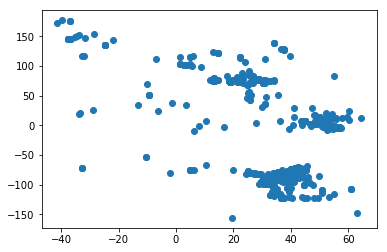

In [46]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage#,pdist
from scipy.spatial.distance import pdist
import numpy as np

print (X.shape) 
plt.scatter(X[:,0], X[:,1])
plt.show()
Z = linkage(X,metric=distance)# - euclidean by default

In [51]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
# Cophenetic Correlation Coefficient - compares (correlates) the actual pairwise distances of all your samples to those implied by the hierarchical clustering
c, coph_dists = cophenet(Z, pdist(X, distance))
c

0.77513018036175763

In [52]:
print(len(X))
print(Z[:20])
print(X[0])
print(X[16])
print(Z[1278])
print (X[32],X[1278])
print (len(Z))

1348
[[    0.    16.     0.     2.]
 [   33.  1348.     0.     3.]
 [   54.  1349.     0.     4.]
 [  102.  1350.     0.     5.]
 [  158.  1351.     0.     6.]
 [  159.  1352.     0.     7.]
 [  176.  1353.     0.     8.]
 [  240.  1354.     0.     9.]
 [  246.  1355.     0.    10.]
 [  251.  1356.     0.    11.]
 [  266.  1357.     0.    12.]
 [  268.  1358.     0.    13.]
 [  279.  1359.     0.    14.]
 [  282.  1360.     0.    15.]
 [  313.  1361.     0.    16.]
 [  375.  1362.     0.    17.]
 [  380.  1363.     0.    18.]
 [  385.  1364.     0.    19.]
 [  394.  1365.     0.    20.]
 [  476.  1366.     0.    21.]]
[ 22.3511148  78.6677428]
[ 22.3511148  78.6677428]
[ 2593.          2606.           249.04667843    47.        ]
[ 44.933143   7.540121] [ 40.0757384 -74.4041622]
1347


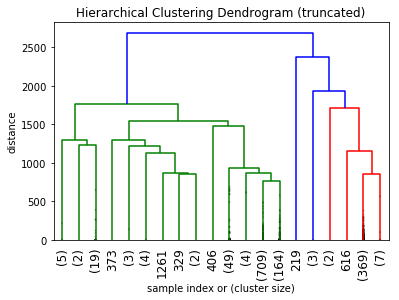

In [54]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=20,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

In [55]:
## Retrieving most popular Loations
print (Z[:50])


[[    0.    16.     0.     2.]
 [   33.  1348.     0.     3.]
 [   54.  1349.     0.     4.]
 [  102.  1350.     0.     5.]
 [  158.  1351.     0.     6.]
 [  159.  1352.     0.     7.]
 [  176.  1353.     0.     8.]
 [  240.  1354.     0.     9.]
 [  246.  1355.     0.    10.]
 [  251.  1356.     0.    11.]
 [  266.  1357.     0.    12.]
 [  268.  1358.     0.    13.]
 [  279.  1359.     0.    14.]
 [  282.  1360.     0.    15.]
 [  313.  1361.     0.    16.]
 [  375.  1362.     0.    17.]
 [  380.  1363.     0.    18.]
 [  385.  1364.     0.    19.]
 [  394.  1365.     0.    20.]
 [  476.  1366.     0.    21.]
 [  494.  1367.     0.    22.]
 [  503.  1368.     0.    23.]
 [  506.  1369.     0.    24.]
 [  507.  1370.     0.    25.]
 [  509.  1371.     0.    26.]
 [  648.  1372.     0.    27.]
 [  707.  1373.     0.    28.]
 [  713.  1374.     0.    29.]
 [  893.  1375.     0.    30.]
 [  897.  1376.     0.    31.]
 [  991.  1377.     0.    32.]
 [ 1030.  1378.     0.    33.]
 [ 1031.

In [56]:
geolocator = Nominatim()
X[575]
print (getLocationByCoordinates (str(X[615][0])+","+str(X[615][1])))

County Line Road, Prince Edward County, Virginia, United States of America


In [57]:
print (Z[219])
print (Z[219,1])
print (X[124])
print (len(Z))
print (getLocationByCoordinates(str(X[100][0])+","+str(X[100][1])))
print (getLocationByCoordinates(str(X[124][0])+","+str(X[124][1])))


[  122.  1566.     0.    43.]
1566.0
[ -31.9527121  115.8604796]
1347
57, Via Roma, None, TO, PIE, Italia
Forrest Chase, Forrest Place, Northbridge, Perth, Western Australia, 6005, Australia


### Diagram Analysis 

<IPython.core.display.Javascript object>


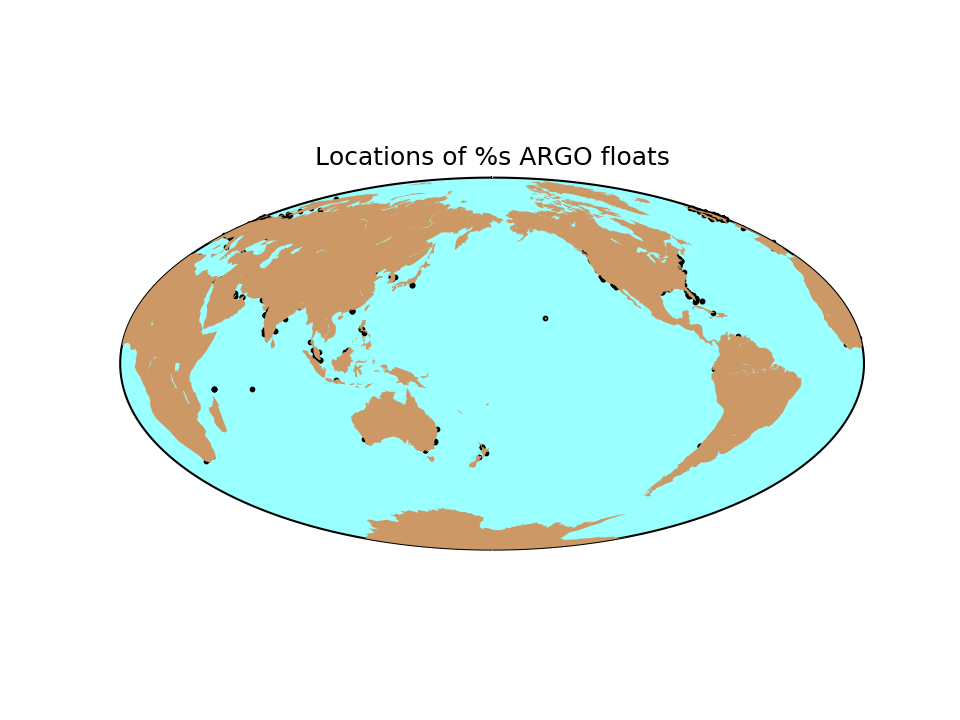

/root/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/root/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/root/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


<IPython.core.display.Javascript object>

In [70]:
%matplotlib notebook
from netCDF4 import Dataset, num2date
import time, calendar, datetime, numpy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import urllib, os


m = Basemap(projection='hammer',lon_0=180)
x, y = m(lons1,lats1)
m.drawmapboundary(fill_color='#99ffff')
m.fillcontinents(color='#cc9966',lake_color='#99ffff')
m.scatter(x,y,3,marker='o',color='k')
plt.title('Locations of %s ARGO floats',fontsize=12)
plt.figure(figsize=(100,100))
plt.show()

<IPython.core.display.Javascript object>


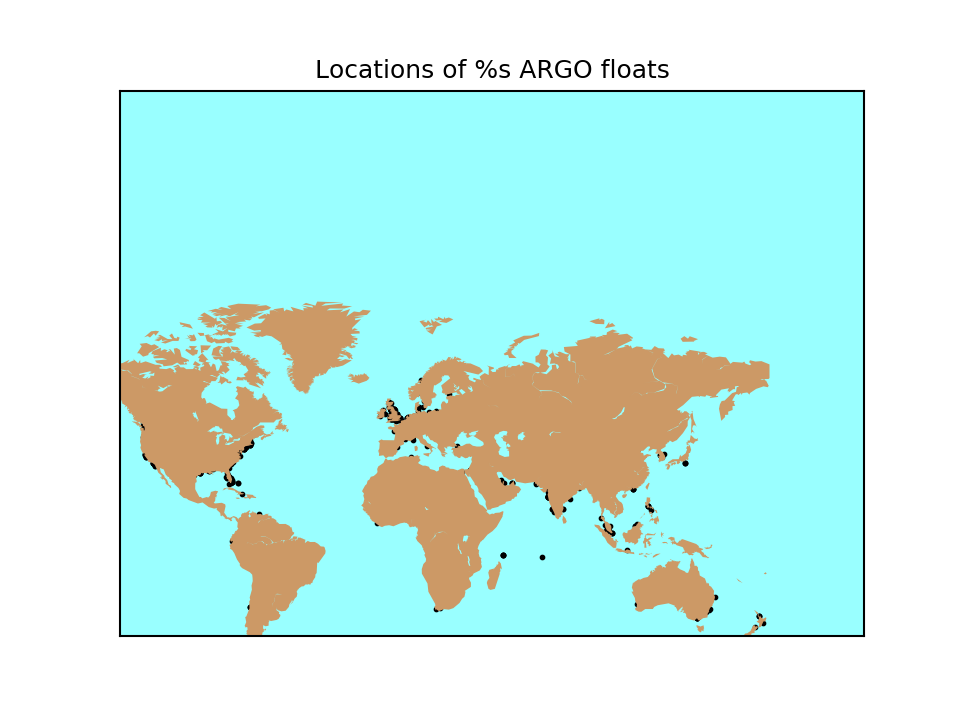

/root/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/root/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/root/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


<IPython.core.display.Javascript object>

In [69]:
%matplotlib notebook
from netCDF4 import Dataset, num2date
import time, calendar, datetime, numpy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import urllib, os
m = Basemap(projection='mill',llcrnrlat=-90,urcrnrlat=90,llcrnrlon=-180,urcrnrlon=180,resolution='c')
x, y = m(lons1,lats1)
m.drawmapboundary(fill_color='#99ffff')
m.fillcontinents(color='#cc9966',lake_color='#99ffff')
m.scatter(x,y,3,marker='o',color='k')
plt.title('Locations of %s ARGO floats',fontsize=12)
plt.figure(figsize=(100,100))
plt.show()

### Clustering